In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import sys
import tarfile
import tensorflow as tf
from six.moves import urllib

print(tf.__version__)

1.4.1


## 1. Prepare CIFAR-10 Dataset (Binary)

In [2]:
def maybe_download_and_extract(
  dest_directory='data',
  data_url='http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'):
  
  """Download and extract the tarball from Alex's website."""
  dest_directory = dest_directory
  if not os.path.exists(dest_directory):
    os.makedirs(dest_directory)
  filename = data_url.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Successfully downloaded', filename, statinfo.st_size, 'bytes.')
  extracted_dir_path = os.path.join(dest_directory, 'cifar-10-batches-bin')
  if not os.path.exists(extracted_dir_path):
    tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [3]:
DATA_DIR = 'data'
DATA_URL = 'http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz'
maybe_download_and_extract(DATA_DIR, DATA_URL)

>> Downloading cifar-10-binary.tar.gz 100.0%()
('Successfully downloaded', 'cifar-10-binary.tar.gz', 170052171, 'bytes.')


In [4]:
def extract_data(index=0, filepath='data/cifar-10-batches-bin/data_batch_5.bin'):
  bytestream = open(filepath, mode='rb')

  label_bytes_length = 1
  image_bytes_length = (32 ** 2) * 3
  record_bytes_length = label_bytes_length + image_bytes_length

  bytestream.seek(record_bytes_length * index, 0)
  label_bytes = bytestream.read(label_bytes_length)
  image_bytes = bytestream.read(image_bytes_length)

  label = np.frombuffer(label_bytes, dtype=np.uint8)  
  image = np.frombuffer(image_bytes, dtype=np.uint8)
  
  image = np.reshape(image, [3, 32, 32])
  image = np.transpose(image, [1, 2, 0])
  image = image.astype(np.float32)
  
  result = {
    'image': image,
    'label': label,
  }
  bytestream.close()
  return result

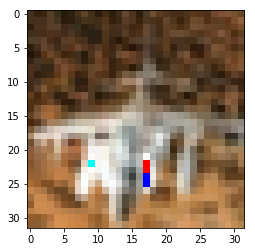

In [5]:
%matplotlib inline
result = extract_data(np.random.randint(1000))
plt.imshow(result['image'])

## Steps to use the TF Estimator APIs
1. Define dataset **metadata** and **global constants**
2. Define **data input function** to read the data from the source + **apply pre-processing**
3. Create TF **feature columns** based on metadata + **extended feature columns**
4. Instantiate a **model function** with the required **feature columns, EstimatorSpecs, & parameters**
5. Define a **serving function**
6. Run **Experiment** by supplying training and validation data, as well as required parameters
7. **Evaluate** the model using test data
8. Perform **predictions**

## 1. Define Parameters

In [6]:
class FLAGS():
  pass

FLAGS.batch_size = 200
FLAGS.max_steps = 1000
FLAGS.eval_steps = 100
FLAGS.save_checkpoints_steps = 100
FLAGS.tf_random_seed = 19851211
FLAGS.model_name = 'cnn-model-01'

# We use a weight decay of 0.0002, which performs better than the 0.0001 that
# was originally suggested.
FLAGS.weight_decay = 2e-4
FLAGS.momentum = 0.9

# If a model is trained with multiple GPUs, prefix all Op names with tower_name
# to differentiate the operations. Note that this prefix is removed from the
# names of the summaries when visualizing a model.
FLAGS.tower_name = 'tower'
FLAGS.use_checkpoint = False

In [7]:
# Process images of this size. Note that this differs from the original CIFAR
# image size of 32 x 32. If one alters this number, then the entire model
# architecture will change and any model would need to be retrained.
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3
NUM_CLASSES = 10

# Global constants describing the CIFAR-10 data set.
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 50000
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 10000

## 2. Define Input Pipeline

In [8]:
def parse_record(raw_record):
  # Every record consists of a label followed by the image, with a fixed number
  # of bytes for each.
  label_bytes = 1
  image_bytes = IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_DEPTH
  record_bytes = label_bytes + image_bytes
  
  # Convert from a string to a vector of uint8 that is record_bytes long.
  record_vector = tf.decode_raw(raw_record, tf.uint8)
  
  # The first byte represents the label, which we convert from uint8 to int32
  # and then to one-hot.
  label = tf.cast(record_vector[0], tf.int32)
  label = tf.one_hot(label, NUM_CLASSES)
  
  # The remaining bytes after the label represent the image, which we reshape
  # from [depth * height * width] to [depth, height, width].
  depth_major = tf.reshape(
    record_vector[label_bytes:record_bytes], [IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
  
  # Convert from [depth, height, width] to [height, width, depth], and cast as
  # float32.
  image = tf.cast(tf.transpose(depth_major, [1, 2, 0]), tf.float32)
  
  return image, label

In [9]:
def preprocess_image(image, is_training=False):
  """Preprocess a single image of layout [height, width, depth]."""
  if is_training:
    # Resize the image to add four extra pixels on each side.
    image = tf.image.resize_image_with_crop_or_pad(
        image, IMAGE_HEIGHT + 8, IMAGE_WIDTH + 8)

    # Randomly crop a [_HEIGHT, _WIDTH] section of the image.
    image = tf.random_crop(image, [IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])

    # Randomly flip the image horizontally.
    image = tf.image.random_flip_left_right(image)

  # Subtract off the mean and divide by the variance of the pixels.
  image = tf.image.per_image_standardization(image)
  return image

In [10]:
def generate_input_fn(file_names, mode=tf.estimator.ModeKeys.EVAL, batch_size=1):
  def _input_fn():
    label_bytes = 1
    image_bytes = IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_DEPTH
    record_bytes = label_bytes + image_bytes
    dataset = tf.data.FixedLengthRecordDataset(filenames=file_names,
                                               record_bytes=record_bytes)

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
    if is_training:
      buffer_size = batch_size * 2 + 1
      dataset = dataset.shuffle(buffer_size=buffer_size)

    dataset = dataset.map(parse_record)
    dataset = dataset.map(lambda image, label: (preprocess_image(image, is_training), label))

    # We call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2 * batch_size)

    # Batch results by up to batch_size, and then fetch the tuple from the
    # iterator.
    dataset = dataset.batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    images, labels = iterator.get_next()

    features = {'images': images}
    return features, labels
  
  return _input_fn

## 3. Define Features

In [11]:
def get_feature_columns():
  feature_columns = {
    'images': tf.feature_column.numeric_column('images', (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH)),
  }
  return feature_columns

In [12]:
feature_columns = get_feature_columns()
print("Feature Columns: {}".format(feature_columns))

Feature Columns: {'images': _NumericColumn(key='images', shape=(32, 32, 3), default_value=None, dtype=tf.float32, normalizer_fn=None)}


## 4. Define an Estimator

In [13]:
def _activation_summary(x):
  """Helper to create summaries for activations.
  Creates a summary that provides a histogram of activations.
  Creates a summary that measures the sparsity of activations.
  Args:
    x: Tensor
  Returns:
    nothing
  """
  # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
  # session. This helps the clarity of presentation on tensorboard.
  tensor_name = re.sub('%s_[0-9]*/' % FLAGS.tower_name, '', x.op.name)
  tf.summary.histogram(tensor_name + '/activations', x)
  tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(x))
  
def _variable_on_cpu(name, shape, initializer):
  """Helper to create a Variable stored on CPU memory.
  Args:
    name: name of the variable
    shape: list of ints
    initializer: initializer for Variable
  Returns:
    Variable Tensor
  """
  with tf.device('/cpu:0'):
    dtype = tf.float32
    var = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
  return var

def _variable_with_weight_decay(name, shape, stddev, wd):
  """Helper to create an initialized Variable with weight decay.
  Note that the Variable is initialized with a truncated normal distribution.
  A weight decay is added only if one is specified.
  Args:
    name: name of the variable
    shape: list of ints
    stddev: standard deviation of a truncated Gaussian
    wd: add L2Loss weight decay multiplied by this float. If None, weight
        decay is not added for this Variable.
  Returns:
    Variable Tensor
  """
  dtype = tf.float32
  var = _variable_on_cpu(
      name,
      shape,
      tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
  if wd is not None:
    weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
    tf.add_to_collection('losses', weight_decay)
  return var

In [14]:
def inference(images):
  with tf.variable_scope('conv1') as scope:
    kernel = _variable_with_weight_decay('weights', shape=[5, 5, 3, 64], stddev=5e-2, wd=0.0)
    conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
    biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
    pre_activation = tf.nn.bias_add(conv, biases)
    conv1 = tf.nn.relu(pre_activation, name=scope.name)
    _activation_summary(conv1)
    
  pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
  norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
  
  with tf.variable_scope('conv2') as scope:
    kernel = _variable_with_weight_decay('weights', shape=[5, 5, 64, 64], stddev=5e-2, wd=0.0)
    conv = tf.nn.conv2d(norm1, kernel, [1, 1, 1, 1], padding='SAME')
    biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.1))
    pre_activation = tf.nn.bias_add(conv, biases)
    conv2 = tf.nn.relu(pre_activation, name=scope.name)
    _activation_summary(conv2)

  norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
  pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')
    
  with tf.variable_scope('local3') as scope:
    pool2_shape = pool2.get_shape()
    dim = pool2_shape[1] * pool2_shape[2] * pool2_shape[3]
    reshape = tf.reshape(pool2, [-1, dim])
    weights = _variable_with_weight_decay('weights', shape=[dim, 384], stddev=0.04, wd=0.004)
    biases = _variable_on_cpu('biases', [384], tf.constant_initializer(0.1))
    local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)
    _activation_summary(local3)

  with tf.variable_scope('local4') as scope:
    weights = _variable_with_weight_decay('weights', shape=[384, 192], stddev=0.04, wd=0.004)
    biases = _variable_on_cpu('biases', [192], tf.constant_initializer(0.1))
    local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name=scope.name)
    _activation_summary(local4)

  with tf.variable_scope('softmax_linear') as scope:
    weights = _variable_with_weight_decay('weights', [192, NUM_CLASSES], stddev=1/192.0, wd=0.0)
    biases = _variable_on_cpu('biases', [NUM_CLASSES], tf.constant_initializer(0.0))
    logits = tf.add(tf.matmul(local4, weights), biases, name=scope.name)
    _activation_summary(logits)

  return logits

In [15]:
def get_loss(logits, labels):
  # Calculate loss, which includes softmax cross entropy and L2 regularization.
  cross_entropy = tf.losses.softmax_cross_entropy(
    logits=logits, onehot_labels=labels)

  # Create a tensor named cross_entropy for logging purposes.
  tf.identity(cross_entropy, name='cross_entropy')
  tf.summary.scalar('cross_entropy', cross_entropy)

  # Add weight decay to the loss.
  loss = cross_entropy + FLAGS.weight_decay * tf.add_n(
      [tf.nn.l2_loss(v) for v in tf.trainable_variables()])
  
  return loss

In [16]:
def get_train_op(loss, params, mode):
  if mode == tf.estimator.ModeKeys.TRAIN:
    # Scale the learning rate linearly with the batch size. When the batch size
    # is 128, the learning rate should be 0.1.
    initial_learning_rate = 0.1 * params.batch_size / 128
    batches_per_epoch = NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN / params.batch_size
    global_step = tf.train.get_or_create_global_step()

    # Multiply the learning rate by 0.1 at 100, 150, and 200 epochs.
    boundaries = [int(batches_per_epoch * epoch) for epoch in [100, 150, 200]]
    values = [initial_learning_rate * decay for decay in [1, 0.1, 0.01, 0.001]]
    learning_rate = tf.train.piecewise_constant(
        tf.cast(global_step, tf.int32), boundaries, values)

    # Create a tensor named learning_rate for logging purposes
    tf.identity(learning_rate, name='learning_rate')
    tf.summary.scalar('learning_rate', learning_rate)

    optimizer = tf.train.MomentumOptimizer(
        learning_rate=learning_rate,
        momentum=FLAGS.momentum)

    # Batch norm requires update ops to be added as a dependency to the train_op
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      train_op = optimizer.minimize(loss, global_step)
  else:
    train_op = None
    
  return train_op

In [17]:
def get_metrics(predictions, labels):
  # Calculate accuracy
  accuracy = tf.metrics.accuracy(predictions['classes'],
                                 tf.argmax(labels, axis=1))

  # Create a tensor named train_accuracy for logging purposes
  tf.identity(accuracy[1], name='train_accuracy')
  tf.summary.scalar('train_accuracy', accuracy[1])
  
  return {'accuracy': accuracy}

In [18]:
def get_estimator(run_config, hparams):
  def _model_fn(features, labels, mode, params):
    # Create the input layers from the features
    feature_columns = list(get_feature_columns().values())

    images = tf.feature_column.input_layer(
      features=features, feature_columns=feature_columns)

    images = tf.reshape(
      images, shape=(-1, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))

    # Calculate logits through CNN
    logits = inference(images)

    # Get predictions
    predictions = {
      'classes': tf.argmax(logits, axis=1),
      'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }

    # Provide an estimator spec for `ModeKeys.PREDICT`
    if mode == tf.estimator.ModeKeys.PREDICT:
      export_outputs = {
        'predictions': tf.estimator.export.PredictOutput(predictions)
      }
      return tf.estimator.EstimatorSpec(mode=mode,
                                        predictions=predictions,
                                        export_outputs=export_outputs)

    loss = get_loss(logits=logits, labels=labels)
    train_op = get_train_op(loss=loss, mode=mode, params=params)
    metrics = get_metrics(predictions=predictions, labels=labels)

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=predictions,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=metrics)

  return tf.estimator.Estimator(model_fn=_model_fn,
                                params=hparams,
                                config=run_config)

## 5. Define Serving Function

In [19]:
def serving_input_fn():

  receiver_tensor = {'images': tf.placeholder(
    shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH], dtype=tf.float32)}
  features = {'images': tf.map_fn(preprocess_image, receiver_tensor['images'])}
  
  return tf.estimator.export.ServingInputReceiver(features, receiver_tensor)

## 6. Train, Evaluate and Export a ML Model

In [20]:
model_dir = 'trained_models/{}'.format(FLAGS.model_name)
train_data_files = ['data/cifar-10-batches-bin/data_batch_{}.bin'.format(i) for i in range(1,5)]
valid_data_files = ['data/cifar-10-batches-bin/data_batch_5.bin']
test_data_files = ['data/cifar-10-batches-bin/test_batch.bin']

In [21]:
hparams = tf.contrib.training.HParams(
  batch_size=FLAGS.batch_size,
  max_steps=FLAGS.max_steps,
)

run_config = tf.estimator.RunConfig(
  save_checkpoints_steps=FLAGS.save_checkpoints_steps,
  tf_random_seed=FLAGS.tf_random_seed,
  model_dir=model_dir
)

estimator = get_estimator(run_config, hparams)

# There is another Exporter named FinalExporter
exporter = tf.estimator.LatestExporter(
  name='Servo',
  serving_input_receiver_fn=serving_input_fn,
  assets_extra=None,
  as_text=False,
  exports_to_keep=5)


train_spec = tf.estimator.TrainSpec(
  input_fn=generate_input_fn(file_names=train_data_files,
                             mode=tf.estimator.ModeKeys.TRAIN,
                             batch_size=hparams.batch_size),
  max_steps=FLAGS.max_steps)

eval_spec = tf.estimator.EvalSpec(
  input_fn=generate_input_fn(file_names=valid_data_files,
                             mode=tf.estimator.ModeKeys.EVAL,
                             batch_size=hparams.batch_size),
  steps=FLAGS.eval_steps, exporters=exporter)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 19851211, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe5129cd290>, '_model_dir': 'trained_models/cnn-model-01', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_master': '', '_save_checkpoints_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_save_summary_steps': 100, '_num_ps_replicas': 0}


In [22]:
if not FLAGS.use_checkpoint:
  print("Removing previous artifacts...")
  shutil.rmtree(model_dir, ignore_errors=True)

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Removing previous artifacts...
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into trained_models/cnn-model-01/model.ckpt.
INFO:tensorflow:loss = 2.53278, step = 1
INFO:tensorflow:Saving checkpoints for 101 into trained_models/cnn-model-01/model.ckpt.
INFO:tensorflow:global_step/sec: 1.00962
INFO:tensorflow:loss = 2.60937, step = 101 (99.048 sec)
INFO:tensorflow:Saving checkpoints for 201 into trained_models/cnn-model-01/model.ckpt.
INFO:tensorflow:global_step/sec: 0.997318
INFO:tensorflow:loss = 2.52636, step = 201 (100.275 sec)
INFO:tensorflow:Saving checkpoints for 301 into trained_models/cnn-model-01/model.ckpt.
INFO:tensorflow:global_step/sec: 1.01459
INFO:tensorflow:loss = 2.39819, step = 301 (98.556 sec)
INFO:tensorflow:Saving check

INFO:tensorflow:Evaluation [37/100]
INFO:tensorflow:Evaluation [38/100]
INFO:tensorflow:Evaluation [39/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [41/100]
INFO:tensorflow:Evaluation [42/100]
INFO:tensorflow:Evaluation [43/100]
INFO:tensorflow:Evaluation [44/100]
INFO:tensorflow:Evaluation [45/100]
INFO:tensorflow:Evaluation [46/100]
INFO:tensorflow:Evaluation [47/100]
INFO:tensorflow:Evaluation [48/100]
INFO:tensorflow:Evaluation [49/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [51/100]
INFO:tensorflow:Evaluation [52/100]
INFO:tensorflow:Evaluation [53/100]
INFO:tensorflow:Evaluation [54/100]
INFO:tensorflow:Evaluation [55/100]
INFO:tensorflow:Evaluation [56/100]
INFO:tensorflow:Evaluation [57/100]
INFO:tensorflow:Evaluation [58/100]
INFO:tensorflow:Evaluation [59/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [61/100]
INFO:tensorflow:Evaluation [62/100]
INFO:tensorflow:Evaluation [63/100]
INFO:tensorflow:Evaluation [

## 6. Evaluate with Estimator

In [23]:
test_input_fn = generate_input_fn(file_names=test_data_files,
                                  mode=tf.estimator.ModeKeys.EVAL,
                                  batch_size=1000)
estimator = get_estimator(run_config, hparams)
print(estimator.evaluate(input_fn=test_input_fn, steps=1))

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 19851211, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe5129cd290>, '_model_dir': 'trained_models/cnn-model-01', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_master': '', '_save_checkpoints_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_save_summary_steps': 100, '_num_ps_replicas': 0}
INFO:tensorflow:Starting evaluation at 2017-12-20-02:34:48
INFO:tensorflow:Restoring parameters from trained_models/cnn-model-01/model.ckpt-1000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-20-02:34:49
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.404, global_step = 1000, loss = 2.02732
{'loss': 2.0273185, 'global_step': 1000, 'accuracy': 0.40400001}


## 7. Evaluate with an exported model

In [24]:
export_dir = model_dir + '/export/Servo/'
saved_model_dir = os.path.join(export_dir, os.listdir(export_dir)[-1]) 

predictor_fn = tf.contrib.predictor.from_saved_model(
  export_dir = saved_model_dir,
  signature_def_key='predictions')

N = 1000
labels = []
images = []

for i in range(N):
  result = extract_data(i, filepath='data/cifar-10-batches-bin/test_batch.bin')
  images.append(result['image'])
  labels.append(result['label'][0])

output = predictor_fn({'images': images})

INFO:tensorflow:Restoring parameters from trained_models/cnn-model-01/export/Servo/1513737287/variables/variables


In [25]:
np.sum([a==r for a, r in zip(labels, output['classes'])]) / float(N)

0.40400000000000003